In [1]:
# imports
import os
import pandas as pd
import numpy as np
import anndata as ad
import torch

# MulitVI

In [2]:
import scvi

from omicsdgd.functions._analysis import compute_expression_error, binary_output_scores, alternative_ATAC_metrics

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## bonemarrow

In [3]:
save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]
train_indices = list(np.where(adata.obs["train_val_test"] == "train")[0])
test_indices = list(np.where(adata.obs["train_val_test"] == "test")[0])
trainset = adata[train_indices, :].copy()
testset = adata[test_indices, :].copy()
sampling_indices = np.random.choice(np.arange(testset.X.shape[0]), 100)
batches = trainset.obs["Site"].unique()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)
adata = None

In [4]:
trainset.var_names_make_unique()
trainset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(trainset, batch_key="Site")
testset.var_names_make_unique()
testset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(testset, batch_key="Site")

# make sure the results directory exists
result_path = "../results/revision/analysis/batch_integration/" + data_name + "/"
plot_path = "../results/revision/plots/" + data_name + "/"
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [5]:
model_names = ["l20_e2_d2", "l20_e2_d2_rs37", "l20_e2_d2_rs8790"]
model_dir = "../results/trained_models/"
random_seeds = [0, 37, 8790]

In [6]:
i = 2
model_name = model_names[i]

model = scvi.model.MULTIVI.load(
    model_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
)

INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_rs8790/model.pt already downloaded      


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


### calculate performance as before per cell and feature

In [17]:
rmse_sample = compute_expression_error(testset, model, library[:,0].unsqueeze(1), modality_switch, error_type='rmse_sample', reduction="sample")

tpr_s, tnr_s, ba_s, _, _ = binary_output_scores(testset, model, library[:,1].unsqueeze(1), modality_switch, threshold=0.5, batch_size=128, reduction="sample", return_all=True)

    0 %
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


    100 %


In [18]:
auprc_s, spearman_s = alternative_ATAC_metrics(model, testset, modality_switch, None, axis=0, scale=False)

In [19]:
df_sample = pd.DataFrame(
    {
        "rmse": rmse_sample.detach().cpu().numpy(),
        "tpr": tpr_s.detach().cpu().numpy(),
        "tnr": tnr_s.detach().cpu().numpy(),
        "ba": ba_s.detach().cpu().numpy(),
        "auprc": auprc_s,
        "spearman": spearman_s,
        "batch": testset.obs["Site"].values,
    }
)
df_sample.to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_RMSE-BA_samplewise_mvi.csv"
)

In [20]:
rmse_sample, tpr_s, tnr_s, ba_s, auprc_s, spearman_s, df_sample = None, None, None, None, None, None, None

In [7]:
rmse_feature = compute_expression_error(testset, model, library[:,0].unsqueeze(1), modality_switch, error_type='rmse_feature', reduction="feature")
df_feature = pd.DataFrame(
    {
        "rmse": rmse_feature.detach().cpu().numpy(),
        "feature_name": testset.var_names[:modality_switch],
        "feature": "rna"
    }
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [8]:
tpr_f, tnr_f, ba_f, _, _ = binary_output_scores(testset, model, library[:,1].unsqueeze(1), modality_switch, threshold=0.5, batch_size=128, reduction="feature", return_all=True)

In [9]:
auprc_f, spearman_f = alternative_ATAC_metrics(model, testset, modality_switch, None, axis=1, scale=False)

In [10]:
df_feature = pd.concat(
    [
        df_feature,
        pd.DataFrame(
            {
                "tpr": tpr_f.detach().cpu().numpy(),
                "tnr": tnr_f.detach().cpu().numpy(),
                "ba": ba_f.detach().cpu().numpy(),
                "auprc": auprc_f,
                "spearman": spearman_f,
                "feature_name": testset.var_names[modality_switch:],
                "feature": "atac"
            }
        )
    ]
)
df_feature.to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_RMSE-BA_genewise_mvi.csv"
)

In [14]:
rmse_feature, tpr_f, tnr_f, ba_f, auprc_f, spearman_f, df_feature = None, None, None, None, None, None, None

In [15]:
model = None

### test out new stuff for ATAC

In [7]:
def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

# function to get the model predictions for ATAC
def get_accessibility(mod, target, switch, batch_size=100):
    n_samples = target.shape[0]
    y_accessibility = torch.zeros((n_samples, target.shape[1]-switch))

    for i in range(int(n_samples/batch_size)+1):
        print(round(i/(int(n_samples/batch_size))*100),'%')
        start = i*batch_size
        end = min((i+1)*batch_size,n_samples)
        indices = np.arange(start,end,1)
        y_accessibility_temp = mod.get_accessibility_estimates(target, indices=indices)
        if type(y_accessibility_temp) is not torch.Tensor:
            if type(y_accessibility_temp) == pd.core.frame.DataFrame:
                y_accessibility_temp = torch.from_numpy(y_accessibility_temp.values)
        y_accessibility[indices,:] = y_accessibility_temp.detach().cpu()

    return y_accessibility

In [8]:
mvi_atac_test = get_accessibility(model, testset, modality_switch)
mvi_atac_test.shape

0 %
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
1 %
3 %
4 %
6 %
7 %
9 %
10 %
12 %
13 %
14 %
16 %
17 %
19 %
20 %
22 %
23 %
25 %
26 %
28 %
29 %
30 %
32 %
33 %
35 %
36 %
38 %
39 %
41 %
42 %
43 %
45 %
46 %
48 %
49 %
51 %
52 %
54 %
55 %
57 %
58 %
59 %
61 %
62 %
64 %
65 %
67 %
68 %
70 %
71 %
72 %
74 %
75 %
77 %
78 %
80 %
81 %
83 %
84 %
86 %
87 %
88 %
90 %
91 %
93 %
94 %
96 %
97 %
99 %
100 %


torch.Size([6925, 116490])

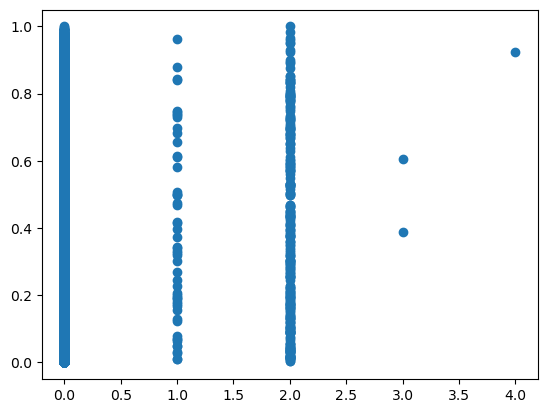

In [10]:
# plot the predictions against the true counts for the first sample

import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(x=np.asarray(testset.X[0,modality_switch:].todense()), y=mvi_atac_test[0,:].numpy())
plt.show()

In [32]:
true_labels = np.asarray(testset.X[0, modality_switch:].todense()).flatten()
binary_labels = binarize(np.asarray(testset.X[0, modality_switch:].todense())).astype(int).flatten()
predicted = mvi_atac_test[0,:].numpy()

In [31]:
binary_labels.shape

(116490,)

In [35]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

precision_binary, recall_binary, _ = precision_recall_curve(binary_labels, predicted)

auprc_binary = auc(recall_binary, precision_binary)

print(f"Binary Model AUPRC: {auprc_binary}")

Binary Model AUPRC: 0.020016748887251138


In [36]:
auprc_binary = average_precision_score(binary_labels, predicted)

print(f"Binary Model AUPRC: {auprc_binary}")

Binary Model AUPRC: 0.020301230539997293


In [39]:
# now try spearman so we don't have to binarize
from scipy.stats import spearmanr

def rank_predictions(predictions):
    """
    Assigns ranks to predictions, with higher values receiving higher ranks.
    
    Args:
    predictions (array-like): The predictions to rank.
    
    Returns:
    numpy.ndarray: The ranks of the predictions.
    """
    # Convert predictions to a numpy array if not already
    predictions = np.array(predictions)
    # Argsort the predictions, then argsort again to get ranks
    ranks = np.argsort(np.argsort(predictions))
    return ranks

#true_ranks = rank_predictions(true_labels)
#mvi_ranks = rank_predictions(predicted)
#mvi_correlation, _ = spearmanr(true_ranks, mvi_ranks)

mvi_correlation, _ = spearmanr(true_labels, predicted)

print(f"Spearman correlation for MVI: {mvi_correlation}")

Spearman correlation for MVI: 0.0645905293337201


In [ ]:
# function to get the model predictions for ATAC

from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr

def alternative_ATAC_metrics(mod, target, switch, scaling_factor, batch_size=100, axis=0, scale=True):
    n_samples = target.shape[0]
    x_accessibility = torch.Tensor(target.X[:,switch:].todense())
    y_accessibility = torch.zeros((n_samples, target.shape[1]-switch))

    for i in range(int(n_samples/batch_size)+1):
        print(round(i/(int(n_samples/batch_size))*100),'%')
        start = i*batch_size
        end = min((i+1)*batch_size,n_samples)
        indices = np.arange(start,end,1)
        y_accessibility_temp = mod.get_accessibility_estimates(target, indices=indices)
        if type(y_accessibility_temp) is not torch.Tensor:
            if type(y_accessibility_temp) == pd.core.frame.DataFrame:
                y_accessibility_temp = torch.from_numpy(y_accessibility_temp.values)
        y_accessibility[indices,:] = y_accessibility_temp.detach().cpu()
    
    if scale:
        y_accessibility = y_accessibility * scaling_factor
    
    # axis 0 is sample-wise, axis 1 feature-wise
    y_auprc = np.zeros(y_accessibility.shape[axis])
    y_spearmanr = np.zeros(y_accessibility.shape[axis])
    if axis == 0:
        for j in range(y_accessibility.shape[axis]):
            # AUPRC
            true_labels = x_accessibility[j,:]
            binary_labels = binarize(true_labels).astype(int)
            predicted = y_accessibility[j,:].numpy()
            y_auprc[j] = average_precision_score(binary_labels, predicted)
            y_spearmanr[j], _ = spearmanr(true_labels, predicted)
    else:
        for j in range(y_accessibility.shape[axis]):
            # AUPRC
            true_labels = x_accessibility[:,j]
            binary_labels = binarize(true_labels).astype(int)
            predicted = y_accessibility[:,j].numpy()
            y_auprc[j] = average_precision_score(binary_labels, predicted)
            y_spearmanr[j], _ = spearmanr(true_labels, predicted)

    return y_auprc, y_spearmanr

### overall AUPRC and Spearman

In [7]:
trainset = None

In [8]:
batch_size = 100
axis = None

n_samples = testset.shape[0]
x_accessibility = torch.Tensor(testset.X[:,modality_switch:].todense())
y_accessibility = torch.zeros((n_samples, testset.shape[1]-modality_switch))

for j in range(int(n_samples/batch_size)+1):
    start = j*batch_size
    end = min((j+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    y_accessibility_temp = model.get_accessibility_estimates(testset, indices=indices)
    if type(y_accessibility_temp) is not torch.Tensor:
        if type(y_accessibility_temp) == pd.core.frame.DataFrame:
            y_accessibility_temp = torch.from_numpy(y_accessibility_temp.values)
    y_accessibility[indices,:] = y_accessibility_temp.detach().cpu()

y_accessibility = y_accessibility * library[:,1].unsqueeze(1)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [9]:
testset = None

from omicsdgd.functions._analysis import binarize

from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr


In [10]:
true_labels = x_accessibility.detach().cpu().numpy().flatten()
predicted = y_accessibility.detach().cpu().numpy().flatten()

x_accessibility, y_accessibility = None, None

In [11]:
y_spearmanr, _ = spearmanr(true_labels[::10], predicted[::10])
y_spearmanr

0.23712617696732277

In [12]:
binary_labels = binarize(true_labels).astype(int)

true_labels = None

In [13]:
y_auprc = average_precision_score(binary_labels[::10], predicted[::10])
y_auprc

0.26081529699812717

In [14]:
pd.DataFrame(
        {
            "auprc": [y_auprc],
            "spearman": [y_spearmanr],
        }
    ).to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_auprc_spearman_mvi.csv"
)

In [ ]:
model = None

### batch integration

In [5]:
model_names = [
    "l20_e2_d2_leftout_site1_scarches",
    "l20_e2_d2_leftout_site2_scarches",
    "l20_e2_d2_leftout_site3_scarches",
    "l20_e2_d2_leftout_site4_scarches",
]

In [6]:
from omicsdgd.functions._analysis import binarize
from sklearn.metrics import average_precision_score

x_accessibility = torch.Tensor(testset.X[:,modality_switch:].todense())
true_labels = x_accessibility.detach().cpu().numpy().flatten()
x_accessibility = None
binary_labels = binarize(true_labels).astype(int)
true_labels = None
batch_size = 100
axis = None
n_samples = testset.shape[0]

In [ ]:
binary_labels = binary_labels[::10]

In [19]:
i = 3
model_name = model_names[i]
# load model
model = scvi.model.MULTIVI.load(
    save_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
)

INFO     File ../results/trained_models/multiVI/human_bonemarrow/l20_e2_d2_leftout_site4_scarches/model.pt already 
         downloaded                                                                                                


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [20]:
# get the predictions
y_accessibility = torch.zeros((n_samples, testset.shape[1]-modality_switch))

for j in range(int(n_samples/batch_size)+1):
    start = j*batch_size
    end = min((j+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    y_accessibility_temp = model.get_accessibility_estimates(testset, indices=indices)
    if type(y_accessibility_temp) is not torch.Tensor:
        if type(y_accessibility_temp) == pd.core.frame.DataFrame:
            y_accessibility_temp = torch.from_numpy(y_accessibility_temp.values)
    y_accessibility[indices,:] = y_accessibility_temp.detach().cpu()

y_accessibility = y_accessibility * library[:,1].unsqueeze(1)
predicted = y_accessibility.detach().cpu().numpy().flatten()
y_accessibility = None
model = None

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [21]:
predicted = predicted[::10]

In [10]:
y_auprc = average_precision_score(binary_labels, predicted)
print(f"Model {model_name} AUPRC: {y_auprc}")

Model l20_e2_d2_leftout_site1_scarches AUPRC: 0.25975587259993305


In [14]:
y_auprc = average_precision_score(binary_labels, predicted)
print(f"Model {model_name} AUPRC: {y_auprc}")

Model l20_e2_d2_leftout_site2_scarches AUPRC: 0.25924887119849777


In [18]:
y_auprc = average_precision_score(binary_labels, predicted)
print(f"Model {model_name} AUPRC: {y_auprc}")

Model l20_e2_d2_leftout_site3_scarches AUPRC: 0.25766518018835755


In [22]:
y_auprc = average_precision_score(binary_labels, predicted)
print(f"Model {model_name} AUPRC: {y_auprc}")

Model l20_e2_d2_leftout_site4_scarches AUPRC: 0.25905025997182063


## mouse gastrulation

In [3]:
import mudata as md
import scipy

In [4]:
save_dir = "../results/trained_models/"
data_name = "mouse_gastrulation"
mudata = md.read("../../data/mouse_gastrulation.h5mu", backed=False)
train_indices = list(np.where(mudata.obs["train_val_test"] == "train")[0])
test_indices = list(np.where(mudata.obs["train_val_test"] == "test")[0])
batches = mudata.obs["stage"].unique()
modality_switch = mudata['rna'].X.shape[1]

data = ad.AnnData(scipy.sparse.hstack((mudata['rna'].X,mudata['atac'].X)))
data.obs = mudata.obs
modality_switch = mudata["rna"].shape[1]
data.var = mudata.var
mudata = None
data.var['feature_types'] = ['rna']*modality_switch+['atac']*(data.shape[1]-modality_switch)
trainset = data[train_indices, :].copy()
testset = data[test_indices, :].copy()
data = None
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense()[:, :modality_switch]), dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense()[:, modality_switch:]), dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)

In [5]:
trainset.var_names_make_unique()
trainset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(trainset, batch_key="stage")
testset.var_names_make_unique()
testset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(testset, batch_key="stage")

# make sure the results directory exists
result_path = "../results/revision/analysis/batch_integration/" + data_name + "/"
plot_path = "../results/revision/plots/" + data_name + "/"

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [6]:
model_names = ["l20_e2_d2", "l20_e2_d2_rs37", "l20_e2_d2_rs8790"]
model_dir = "../results/trained_models/"
random_seeds = [0, 37, 8790]

In [20]:
i = 2
model_name = model_names[i]

model = scvi.model.MULTIVI.load(
    model_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
)

INFO     File ../results/trained_models/multiVI/mouse_gastrulation/l20_e2_d2_rs8790/model.pt already downloaded    


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/model/base/_base_model.py:691: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  _validate_var_names(adata, var_names)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [21]:
rmse_sample = compute_expression_error(testset, model, library[:,0].unsqueeze(1), modality_switch, error_type='rmse_sample', reduction="sample")

    0 %
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


    100 %


In [22]:
tpr_s, tnr_s, ba_s, _, _ = binary_output_scores(testset, model, library[:,1].unsqueeze(1), modality_switch, threshold=0.5, batch_size=128, reduction="sample", return_all=True)

In [23]:
auprc_s, spearman_s = alternative_ATAC_metrics(model, testset, modality_switch, None, axis=0, scale=False)

In [9]:
auprc_s.mean()

0.3850507290738613

In [24]:
df_sample = pd.DataFrame(
    {
        "rmse": rmse_sample.detach().cpu().numpy(),
        "tpr": tpr_s.detach().cpu().numpy(),
        "tnr": tnr_s.detach().cpu().numpy(),
        "ba": ba_s.detach().cpu().numpy(),
        "auprc": auprc_s,
        "spearman": spearman_s,
        "batch": testset.obs["stage"].values,
    }
)
df_sample.to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_RMSE-BA_samplewise_mvi.csv"
)

rmse_sample, tpr_s, tnr_s, ba_s, auprc_s, spearman_s, df_sample = None, None, None, None, None, None, None

In [25]:
rmse_feature = compute_expression_error(testset, model, library[:,0].unsqueeze(1), modality_switch, error_type='rmse_feature', reduction="feature")
df_feature = pd.DataFrame(
    {
        "rmse": rmse_feature.detach().cpu().numpy(),
        "feature_name": testset.var_names[:modality_switch],
        "feature": "rna"
    }
)

In [26]:
tpr_f, tnr_f, ba_f, _, _ = binary_output_scores(testset, model, library[:,1].unsqueeze(1), modality_switch, threshold=0.5, batch_size=128, reduction="feature", return_all=True)

In [27]:
auprc_f, spearman_f = alternative_ATAC_metrics(model, testset, modality_switch, None, axis=1, scale=False)

In [11]:
auprc_f.mean()

0.2858748079054493

In [28]:
df_feature = pd.concat(
    [
        df_feature,
        pd.DataFrame(
            {
                "tpr": tpr_f.detach().cpu().numpy(),
                "tnr": tnr_f.detach().cpu().numpy(),
                "ba": ba_f.detach().cpu().numpy(),
                "auprc": auprc_f,
                "spearman": spearman_f,
                "feature_name": testset.var_names[modality_switch:],
                "feature": "atac"
            }
        )
    ]
)
df_feature.to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_RMSE-BA_genewise_mvi.csv"
)

rmse_feature, tpr_f, tnr_f, ba_f, auprc_f, spearman_f, df_feature = None, None, None, None, None, None, None

#model = None

In [29]:
batch_size = 100
axis = None

n_samples = testset.shape[0]
x_accessibility = torch.Tensor(testset.X[:,modality_switch:].todense())
y_accessibility = torch.zeros((n_samples, testset.shape[1]-modality_switch))

for j in range(int(n_samples/batch_size)+1):
    start = j*batch_size
    end = min((j+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    y_accessibility_temp = model.get_accessibility_estimates(testset, indices=indices)
    if type(y_accessibility_temp) is not torch.Tensor:
        if type(y_accessibility_temp) == pd.core.frame.DataFrame:
            y_accessibility_temp = torch.from_numpy(y_accessibility_temp.values)
    y_accessibility[indices,:] = y_accessibility_temp.detach().cpu()

y_accessibility = y_accessibility * library[:,1].unsqueeze(1)

In [30]:
from omicsdgd.functions._analysis import binarize

from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr

true_labels = x_accessibility.detach().cpu().numpy().flatten()
binary_labels = binarize(true_labels).astype(int)
predicted = y_accessibility.detach().cpu().numpy().flatten()

In [31]:
x_accessibility, y_accessibility = None, None

In [10]:
len(true_labels)

397235332

In [32]:
y_auprc = average_precision_score(binary_labels, predicted)

In [33]:
y_auprc

0.4314197689395455

In [34]:
y_spearmanr, _ = spearmanr(true_labels[::10], predicted[::10])

In [35]:
y_spearmanr

0.37888100935297503

In [36]:
pd.DataFrame(
        {
            "auprc": [y_auprc],
            "spearman": [y_spearmanr],
        }
    ).to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_auprc_spearman_mvi.csv"
)

## mouse brain

In [3]:
import mudata as md
import scipy

In [4]:
save_dir = "../results/trained_models/"
data_name = "human_brain"
mudata = md.read("../../data/human_brain.h5mu", backed=False)
train_indices = list(np.where(mudata.obs["train_val_test"] == "train")[0])
test_indices = list(np.where(mudata.obs["train_val_test"] == "test")[0])
modality_switch = mudata['rna'].X.shape[1]
trainset = mudata[train_indices, :].copy()

data = ad.AnnData(scipy.sparse.hstack((mudata['rna'].X,mudata['atac'].X)))
data.obs = mudata.obs
modality_switch = mudata["rna"].shape[1]
data.var = mudata.var
mudata = None
data.var['feature_types'] = ['rna']*modality_switch+['atac']*(data.shape[1]-modality_switch)
trainset = data[train_indices, :].copy()
testset = data[test_indices, :].copy()
mudata = None
data = None
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense()[:, :modality_switch]), dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense()[:, modality_switch:]), dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)

In [5]:
trainset.var_names_make_unique()
trainset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(trainset)
testset.var_names_make_unique()
testset.obs["modality"] = "paired"
scvi.model.MULTIVI.setup_anndata(testset)

# make sure the results directory exists
result_path = "../results/revision/analysis/batch_integration/" + data_name + "/"
plot_path = "../results/revision/plots/" + data_name + "/"
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [6]:
model_names = ["l20_e1_d1", "l20_e1_d1_rs37", "l20_e1_d1_rs8790"]
model_dir = "../results/trained_models/"
random_seeds = [0, 37, 8790]

In [27]:
i = 2
model_name = model_names[i]

model = scvi.model.MULTIVI.load(
    model_dir + "multiVI/" + data_name + "/" + model_name, adata=trainset
)

INFO     File ../results/trained_models/multiVI/human_brain/l20_e1_d1_rs8790/model.pt already downloaded           


/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scvi/model/base/_base_model.py:691: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  _validate_var_names(adata, var_names)
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [28]:
rmse_sample = compute_expression_error(testset, model, library[:,0].unsqueeze(1), modality_switch, error_type='rmse_sample', reduction="sample", batch_size=128)

tpr_s, tnr_s, ba_s, _, _ = binary_output_scores(testset, model, library[:,1].unsqueeze(1), modality_switch, threshold=0.5, batch_size=128, reduction="sample", return_all=True)

auprc_s, spearman_s = alternative_ATAC_metrics(model, testset, modality_switch, None, axis=0, scale=False)

df_sample = pd.DataFrame(
    {
        "rmse": rmse_sample.detach().cpu().numpy(),
        "tpr": tpr_s.detach().cpu().numpy(),
        "tnr": tnr_s.detach().cpu().numpy(),
        "ba": ba_s.detach().cpu().numpy(),
        "auprc": auprc_s,
        "spearman": spearman_s
    }
)
df_sample.to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_RMSE-BA_samplewise_mvi.csv"
)

rmse_sample, tpr_s, tnr_s, ba_s, auprc_s, spearman_s, df_sample = None, None, None, None, None, None, None

    0 %
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
    50 %
    100 %


In [29]:
rmse_feature = compute_expression_error(testset, model, library[:,0].unsqueeze(1), modality_switch, error_type='rmse_feature', reduction="feature", batch_size=128)
df_feature = pd.DataFrame(
    {
        "rmse": rmse_feature.detach().cpu().numpy(),
        "feature_name": testset.var_names[:modality_switch],
        "feature": "rna"
    }
)

tpr_f, tnr_f, ba_f, _, _ = binary_output_scores(testset, model, library[:,1].unsqueeze(1), modality_switch, threshold=0.5, batch_size=128, reduction="feature", return_all=True)

auprc_f, spearman_f = alternative_ATAC_metrics(model, testset, modality_switch, None, axis=1, scale=False)

df_feature = pd.concat(
    [
        df_feature,
        pd.DataFrame(
            {
                "tpr": tpr_f.detach().cpu().numpy(),
                "tnr": tnr_f.detach().cpu().numpy(),
                "ba": ba_f.detach().cpu().numpy(),
                "auprc": auprc_f,
                "spearman": spearman_f,
                "feature_name": testset.var_names[modality_switch:],
                "feature": "atac"
            }
        )
    ]
)
df_feature.to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_RMSE-BA_genewise_mvi.csv"
)

rmse_feature, tpr_f, tnr_f, ba_f, auprc_f, spearman_f, df_feature = None, None, None, None, None, None, None

#model = None

/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/dbm829/anaconda3/envs/multidgd-paper/lib/python3.9/site-packages/skle

In [30]:
batch_size = 100
axis = None

n_samples = testset.shape[0]
x_accessibility = torch.Tensor(testset.X[:,modality_switch:].todense())
y_accessibility = torch.zeros((n_samples, testset.shape[1]-modality_switch))

for j in range(int(n_samples/batch_size)+1):
    start = j*batch_size
    end = min((j+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    y_accessibility_temp = model.get_accessibility_estimates(testset, indices=indices)
    if type(y_accessibility_temp) is not torch.Tensor:
        if type(y_accessibility_temp) == pd.core.frame.DataFrame:
            y_accessibility_temp = torch.from_numpy(y_accessibility_temp.values)
    y_accessibility[indices,:] = y_accessibility_temp.detach().cpu()

y_accessibility = y_accessibility * library[:,1].unsqueeze(1)

In [31]:
from omicsdgd.functions._analysis import binarize

from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr

true_labels = x_accessibility.detach().cpu().numpy().flatten()
binary_labels = binarize(true_labels).astype(int)
predicted = y_accessibility.detach().cpu().numpy().flatten()

x_accessibility, y_accessibility = None, None

In [32]:
y_auprc = average_precision_score(binary_labels, predicted)
y_auprc

0.3996562971114939

In [33]:
y_spearmanr, _ = spearmanr(true_labels[::10], predicted[::10])
y_spearmanr

0.3272735775081144

In [34]:
pd.DataFrame(
        {
            "auprc": [y_auprc],
            "spearman": [y_spearmanr],
        }
    ).to_csv(
    result_path
    + data_name
    + "_rs"
    + str(random_seeds[i])
    + "_auprc_spearman_mvi.csv"
)

# multiDGD

In [ ]:
save_dir = "../results/trained_models/"
data_name = "human_bonemarrow"
adata = ad.read_h5ad("../../data/" + data_name + ".h5ad")
adata.X = adata.layers["counts"]
train_indices = list(np.where(adata.obs["train_val_test"] == "train")[0])
test_indices = list(np.where(adata.obs["train_val_test"] == "test")[0])
trainset = adata[train_indices, :].copy()
testset = adata[test_indices, :].copy()
sampling_indices = np.random.choice(np.arange(testset.X.shape[0]), 100)
batches = trainset.obs["Site"].unique()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)
adata = None

In [4]:
from omicsdgd import DGD
#from omicsdgd.functions._analysis import testset_reconstruction_evaluation_extended, compute_expression_error, binary_output_scores, calculate_mean_errors, alternative_ATAC_metrics

In [5]:
result_path = "../results/revision/analysis/batch_integration/" + data_name + "/"
plot_path = "../results/revision/plots/" + data_name + "/"

In [6]:
model_name = "human_bonemarrow_l20_h2-3_test50e"

In [7]:
model = DGD.load(
    data=trainset, save_dir=save_dir + data_name + "/", model_name=model_name
)

CUDA Available: False
Number of GPUs: 0
using device:  cpu
check: modality names are  ['GEX', 'ATAC']

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


In [8]:
trainset = None

In [9]:
test_predictions = model.predict_from_representation(
    model.test_rep, model.correction_test_rep
)

In [10]:
model = None

### have a look

In [11]:
# randomly pick 100 samples to evaluate
# plot their predictions against the true counts in a 10x10 grid

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import spearmanr

n_samples = 100
sampling_indices = np.random.choice(np.arange(testset.X.shape[0]), n_samples)

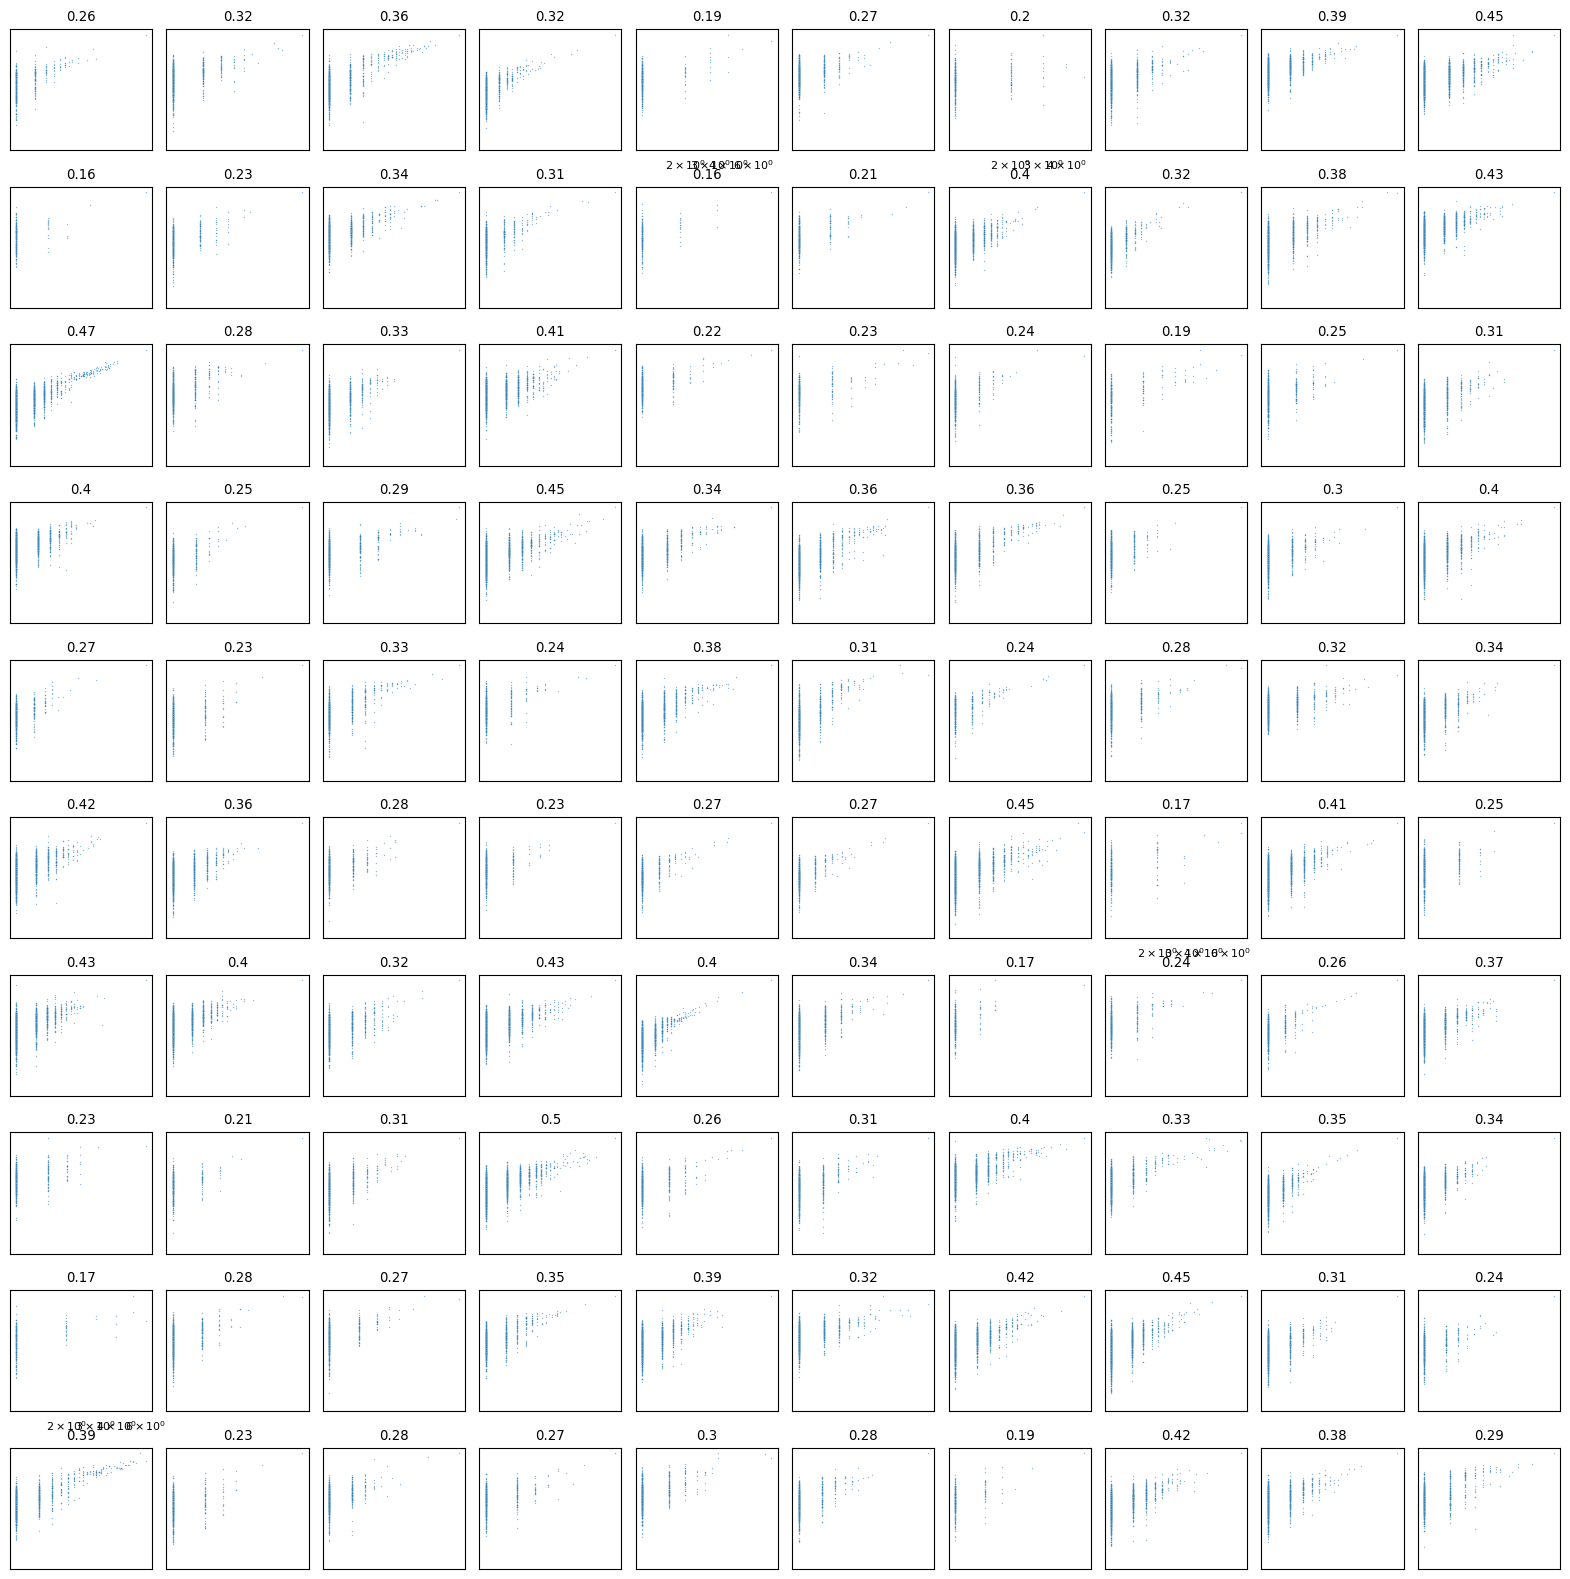

Average correlation: 0.31197173728328187


In [17]:
# RNA
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.1, hspace=0.3)
# make the font size smaller
plt.rc('font', size=8)

avg_corr = 0

for i in range(n_samples):
    true_values = np.asarray(testset.X[sampling_indices[i], :modality_switch].todense()).flatten()
    predicted = (test_predictions[0][sampling_indices[i], :].detach() * library[sampling_indices[i],0]).numpy()
    ax = plt.subplot(gs[i])
    sns.scatterplot(
        x=true_values,
        y=predicted,
        s=1,
        alpha=0.5,
        ax=ax,
    )
    # set scales to log
    ax.set_xscale("log")
    ax.set_yscale("log")
    # remove all the ticks
    ax.tick_params(
        axis="both", which="both", bottom=False, top=False, left=False, right=False
    )
    # remove all tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # calculate the spearman correlation and plot it as the title
    correlation, _ = spearmanr(true_values, predicted)
    avg_corr += correlation
    ax.set_title(f"{round(correlation, 2)}")
plt.show()
print(f"Average correlation: {avg_corr/n_samples}")

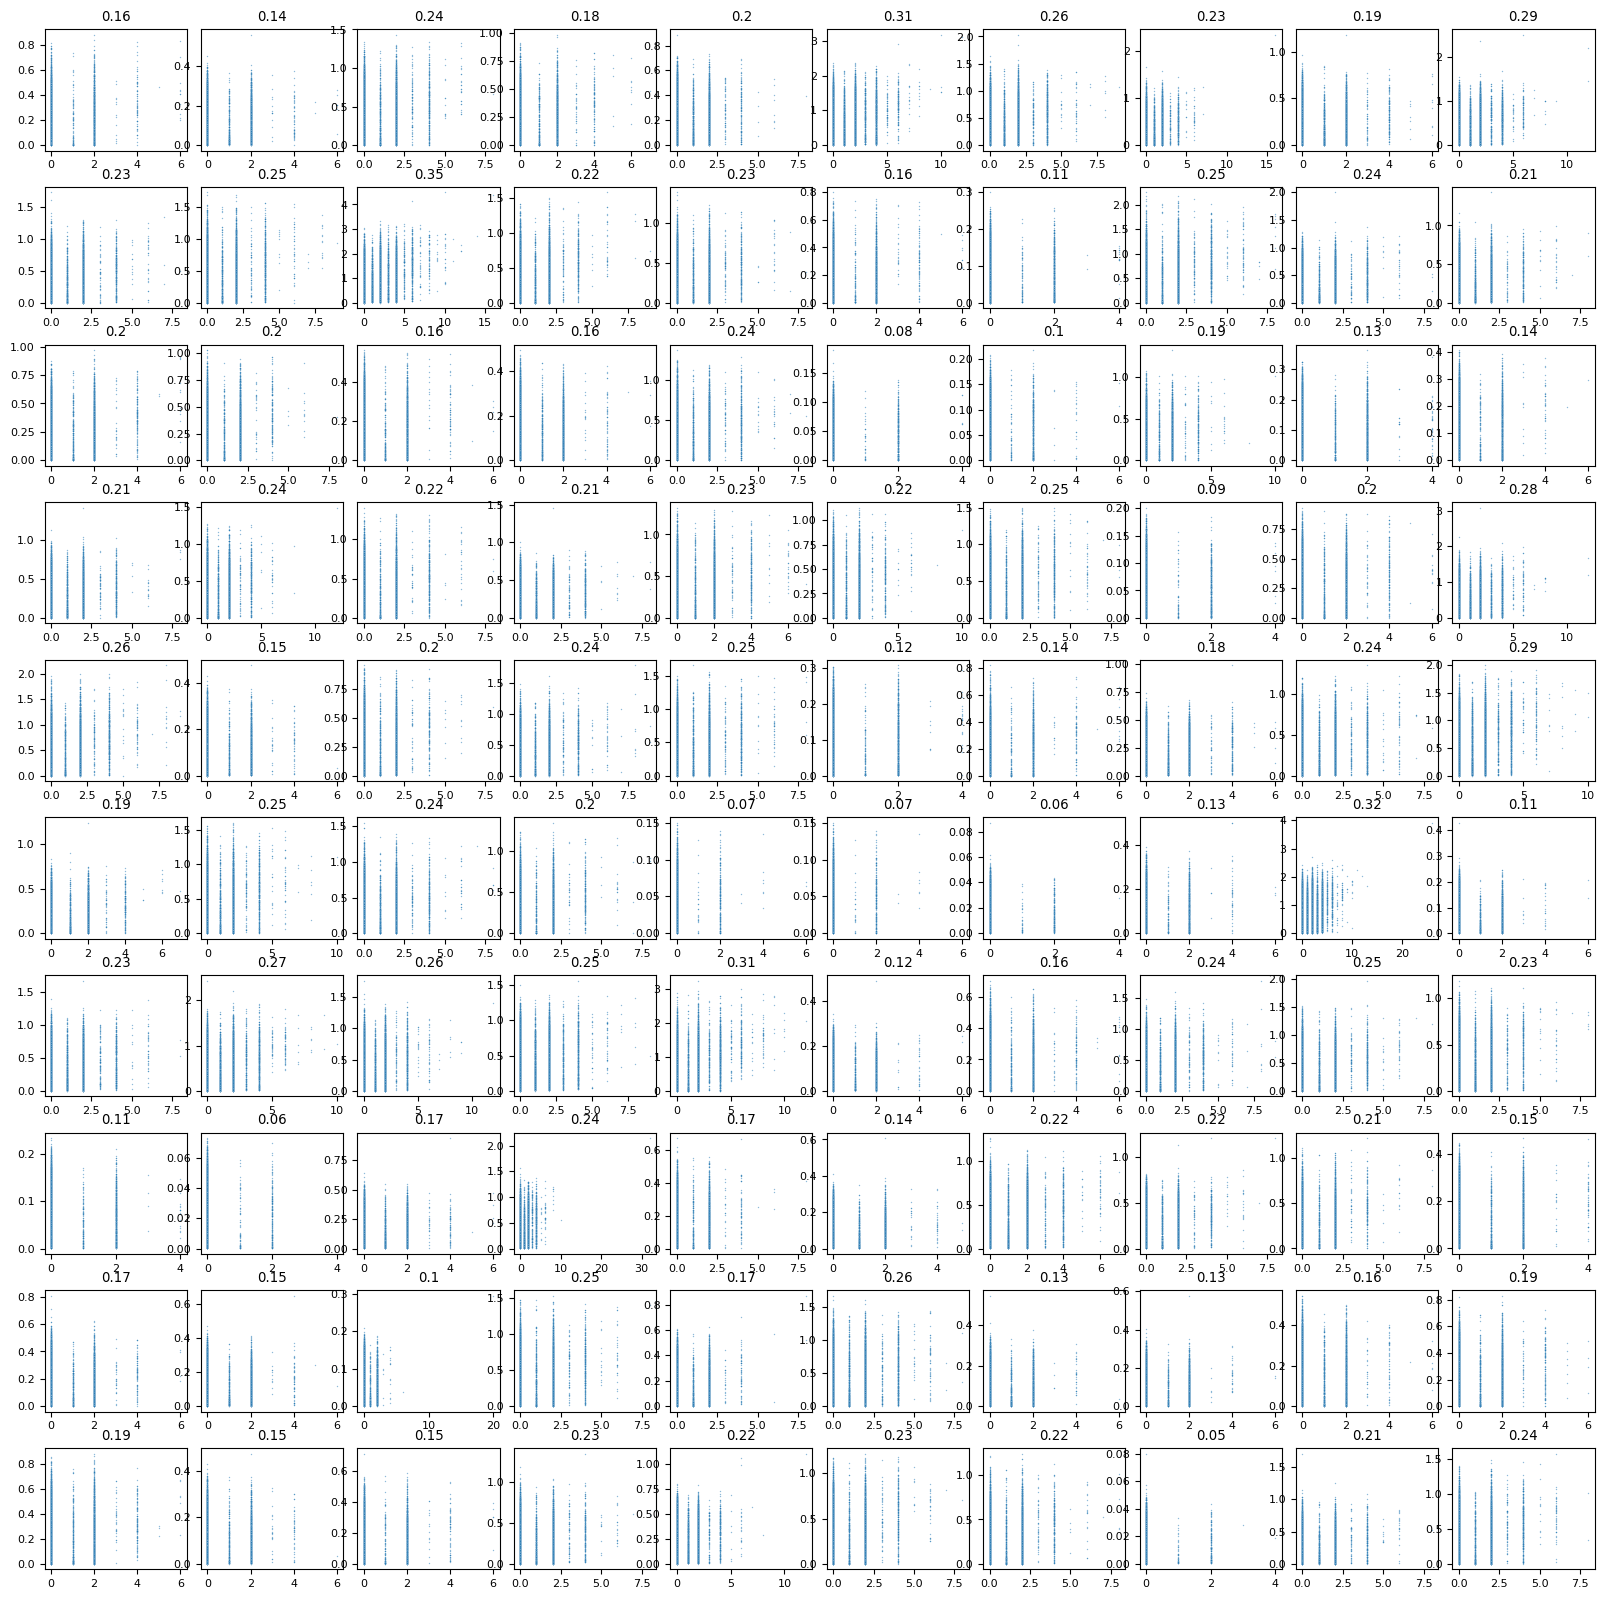

Average correlation: 0.1954363422987461


In [20]:
# RNA
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.1, hspace=0.3)
# make the font size smaller
plt.rc('font', size=8)

avg_corr = 0

for i in range(n_samples):
    true_values = np.asarray(testset.X[sampling_indices[i], modality_switch:].todense()).flatten()
    predicted = (test_predictions[1][sampling_indices[i], :].detach() * library[sampling_indices[i],1]).numpy()
    ax = plt.subplot(gs[i])
    sns.scatterplot(
        x=true_values,
        y=predicted,
        s=1,
        alpha=0.5,
        ax=ax,
    )
    # set scales to log
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    # remove all the ticks
    #ax.tick_params(
    #    axis="both", which="both", bottom=False, top=False, left=False, right=False
    #)
    # remove all tick labels
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    # calculate the spearman correlation and plot it as the title
    correlation, _ = spearmanr(true_values, predicted)
    avg_corr += correlation
    ax.set_title(f"{round(correlation, 2)}")
plt.show()
print(f"Average correlation: {avg_corr/n_samples}")

In [21]:
sampling_indices_features = np.random.choice(np.arange(testset.X.shape[1]-modality_switch), n_samples)

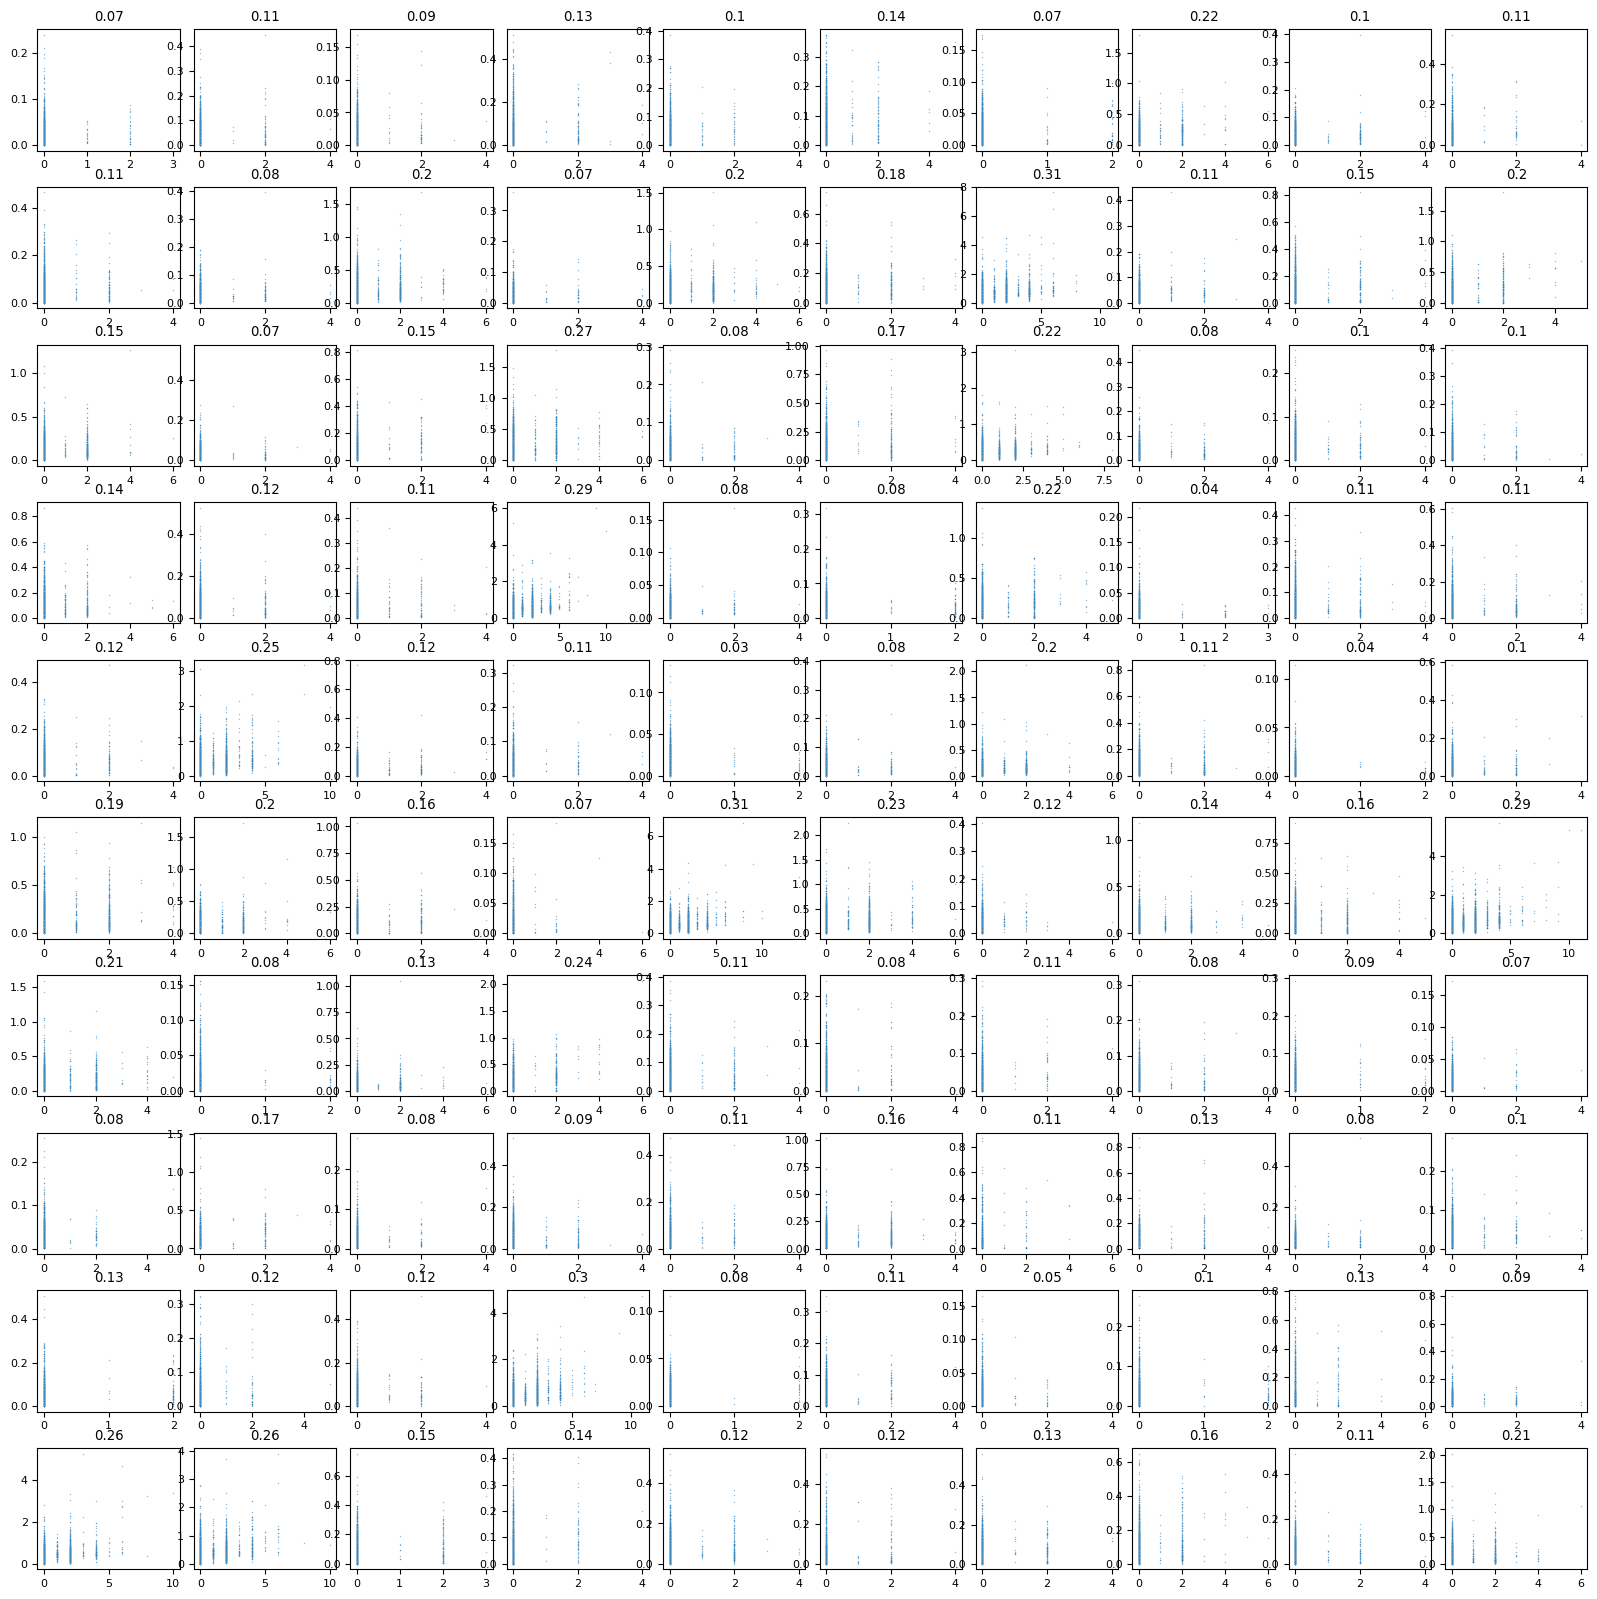

Average correlation: 0.13651807485896003


In [25]:
# RNA
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.1, hspace=0.3)
# make the font size smaller
plt.rc('font', size=8)

avg_corr = 0

for i in range(n_samples):
    true_values = np.asarray(testset.X[:,sampling_indices_features[i]+modality_switch].todense()).flatten()
    predicted = (test_predictions[1][:, sampling_indices_features[i]].detach() * library[:,1]).numpy()
    ax = plt.subplot(gs[i])
    sns.scatterplot(
        x=true_values,
        y=predicted,
        s=1,
        alpha=0.5,
        ax=ax,
    )
    # set scales to log
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    # remove all the ticks
    #ax.tick_params(
    #    axis="both", which="both", bottom=False, top=False, left=False, right=False
    #)
    # remove all tick labels
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    # calculate the spearman correlation and plot it as the title
    correlation, _ = spearmanr(true_values, predicted)
    avg_corr += correlation
    ax.set_title(f"{round(correlation, 2)}")
plt.show()
print(f"Average correlation: {avg_corr/n_samples}")

### balanced accuracy

In [30]:
# calculate the balanced accuracy sample-wise

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

n_samples = testset.shape[0]
true_positives = torch.zeros((n_samples))
false_positives = torch.zeros((n_samples))
true_negatives = torch.zeros((n_samples))
false_negatives = torch.zeros((n_samples))

batch_size = 100
for i in range(int(n_samples/batch_size)+1):
    start = i*batch_size
    end = min((i+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    x_accessibility = binarize(torch.Tensor(testset.X[indices,modality_switch:].todense())).int()
    y_accessibility = test_predictions[1][indices,:].detach().cpu() * library[indices,1].unsqueeze(1)
    y_accessibility = y_accessibility.detach().cpu()
    y_accessibility = binarize(y_accessibility, 0.2).int()

    p = (x_accessibility == 1)
    pp = (y_accessibility == 1)
    true_positives[indices] = torch.logical_and(p,pp).sum(-1).float()
    true_negatives[indices] = torch.logical_and(~p,~pp).sum(-1).float()
    false_positives[indices] = (y_accessibility > x_accessibility).sum(-1).float()
    false_negatives[indices] = (y_accessibility < x_accessibility).sum(-1).float()

tpr = true_positives / (true_positives + false_negatives) # sensitivity
tnr = true_negatives / (true_negatives + false_positives) # specificity
fpr = 1 - tnr
fnr = 1 - tpr
balanced_accuracy = (tpr + tnr) / 2

true_negatives, false_negatives, true_positives, false_positives = None, None, None, None

torch.Size([6925])


In [31]:
balanced_accuracy.mean()

tensor(0.7119)

In [33]:
# calculate the balanced accuracy feature-wise

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

n_samples = testset.shape[1] - modality_switch
true_positives = torch.zeros((n_samples))
false_positives = torch.zeros((n_samples))
true_negatives = torch.zeros((n_samples))
false_negatives = torch.zeros((n_samples))

batch_size = 100
for i in range(int(n_samples/batch_size)+1):
    start = i*batch_size
    end = min((i+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    x_accessibility = binarize(torch.Tensor(testset.X[:,modality_switch:].todense()[:,indices])).int()
    y_accessibility = test_predictions[1][:,indices].detach().cpu() * library[:,1].unsqueeze(1)
    y_accessibility = y_accessibility.detach().cpu()
    y_accessibility = binarize(y_accessibility, 0.2).int()

    p = (x_accessibility == 1)
    pp = (y_accessibility == 1)
    true_positives[indices] = torch.logical_and(p,pp).sum(0).float()
    true_negatives[indices] = torch.logical_and(~p,~pp).sum(0).float()
    false_positives[indices] = (y_accessibility > x_accessibility).sum(0).float()
    false_negatives[indices] = (y_accessibility < x_accessibility).sum(0).float()

tpr = true_positives / (true_positives + false_negatives) # sensitivity
tnr = true_negatives / (true_negatives + false_positives) # specificity
fpr = 1 - tnr
fnr = 1 - tpr
balanced_accuracy = (tpr + tnr) / 2

true_negatives, false_negatives, true_positives, false_positives = None, None, None, None

In [34]:
balanced_accuracy.mean()

tensor(0.5619)

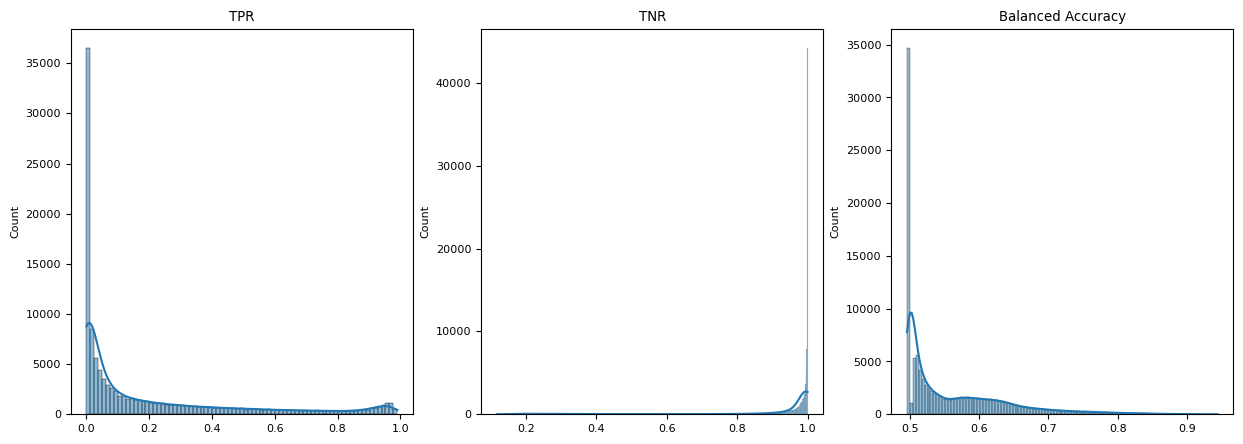

In [35]:
# plot the distributions as histograms of tpr, tnr and balanced accuracy

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(tpr, kde=True, ax=ax[0])
ax[0].set_title("TPR")
sns.histplot(tnr, kde=True, ax=ax[1])
ax[1].set_title("TNR")
sns.histplot(balanced_accuracy, kde=True, ax=ax[2])
ax[2].set_title("Balanced Accuracy")
plt.show()

In [29]:
# calculate the balanced accuracy of the whole set (sample-wise)

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

n_samples = testset.shape[0]
true_positives = torch.zeros((n_samples))
false_positives = torch.zeros((n_samples))
true_negatives = torch.zeros((n_samples))
false_negatives = torch.zeros((n_samples))

batch_size = 100
for i in range(int(n_samples/batch_size)+1):
    start = i*batch_size
    end = min((i+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    x_accessibility = binarize(torch.Tensor(testset.X[indices,modality_switch:].todense())).int()
    y_accessibility = test_predictions[1][indices,:].detach().cpu() * library[indices,1].unsqueeze(1)
    y_accessibility = y_accessibility.detach().cpu()
    y_accessibility = binarize(y_accessibility, 0.2).int()

    p = (x_accessibility == 1)
    pp = (y_accessibility == 1)
    true_positives[indices] = torch.logical_and(p,pp).sum(-1).float()
    true_negatives[indices] = torch.logical_and(~p,~pp).sum(-1).float()
    false_positives[indices] = (y_accessibility > x_accessibility).sum(-1).float()
    false_negatives[indices] = (y_accessibility < x_accessibility).sum(-1).float()

tpr = true_positives.mean() / (true_positives.mean() + false_negatives.mean()) # sensitivity
tnr = true_negatives.mean() / (true_negatives.mean() + false_positives.mean()) # specificity
fpr = 1 - tnr
fnr = 1 - tpr
balanced_accuracy = (tpr + tnr) / 2

true_negatives, false_negatives, true_positives, false_positives = None, None, None, None
print(balanced_accuracy)

tensor(0.7647)


In [38]:
# calculate the balanced accuracy for the whole set (feature-wise first)

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

n_samples = testset.shape[1] - modality_switch
true_positives = torch.zeros((n_samples))
false_positives = torch.zeros((n_samples))
true_negatives = torch.zeros((n_samples))
false_negatives = torch.zeros((n_samples))

batch_size = 100
for i in range(int(n_samples/batch_size)+1):
    start = i*batch_size
    end = min((i+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    x_accessibility = binarize(torch.Tensor(testset.X[:,modality_switch:].todense()[:,indices])).int()
    y_accessibility = test_predictions[1][:,indices].detach().cpu() * library[:,1].unsqueeze(1)
    y_accessibility = y_accessibility.detach().cpu()
    y_accessibility = binarize(y_accessibility, 0.2).int()

    p = (x_accessibility == 1)
    pp = (y_accessibility == 1)
    true_positives[indices] = torch.logical_and(p,pp).sum(0).float()
    true_negatives[indices] = torch.logical_and(~p,~pp).sum(0).float()
    false_positives[indices] = (y_accessibility > x_accessibility).sum(0).float()
    false_negatives[indices] = (y_accessibility < x_accessibility).sum(0).float()

tpr = true_positives.mean() / (true_positives.mean() + false_negatives.mean()) # sensitivity
tnr = true_negatives.mean() / (true_negatives.mean() + false_positives.mean()) # specificity
fpr = 1 - tnr
fnr = 1 - tpr
balanced_accuracy = (tpr + tnr) / 2

true_negatives, false_negatives, true_positives, false_positives = None, None, None, None
print(balanced_accuracy)

tensor(0.7647)


In [39]:
# calculate the balanced accuracy of the whole set (sum all)

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

n_samples = testset.shape[0]
true_positives = torch.zeros((n_samples))
false_positives = torch.zeros((n_samples))
true_negatives = torch.zeros((n_samples))
false_negatives = torch.zeros((n_samples))

batch_size = 100
for i in range(int(n_samples/batch_size)+1):
    start = i*batch_size
    end = min((i+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    x_accessibility = binarize(torch.Tensor(testset.X[indices,modality_switch:].todense())).int()
    y_accessibility = test_predictions[1][indices,:].detach().cpu() * library[indices,1].unsqueeze(1)
    y_accessibility = y_accessibility.detach().cpu()
    y_accessibility = binarize(y_accessibility, 0.2).int()

    p = (x_accessibility == 1)
    pp = (y_accessibility == 1)
    true_positives[indices] = torch.logical_and(p,pp).sum(-1).float()
    true_negatives[indices] = torch.logical_and(~p,~pp).sum(-1).float()
    false_positives[indices] = (y_accessibility > x_accessibility).sum(-1).float()
    false_negatives[indices] = (y_accessibility < x_accessibility).sum(-1).float()

tpr = true_positives.sum() / (true_positives.sum() + false_negatives.sum()) # sensitivity
tnr = true_negatives.sum() / (true_negatives.sum() + false_positives.sum()) # specificity
fpr = 1 - tnr
fnr = 1 - tpr
balanced_accuracy = (tpr + tnr) / 2

true_negatives, false_negatives, true_positives, false_positives = None, None, None, None
print(balanced_accuracy)

tensor(0.7647)


In [11]:
# calculate the balanced accuracy of the whole set (invidually)

def binarize(x, threshold=0.5):
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

n_samples = testset.shape[0]
true_positives = torch.zeros((testset.shape[0], testset.shape[1]-modality_switch))
false_positives = torch.zeros((testset.shape[0], testset.shape[1]-modality_switch))
true_negatives = torch.zeros((testset.shape[0], testset.shape[1]-modality_switch))
false_negatives = torch.zeros((testset.shape[0], testset.shape[1]-modality_switch))

In [12]:
batch_size = 100
for i in range(int(n_samples/batch_size)+1):
    start = i*batch_size
    end = min((i+1)*batch_size,n_samples)
    indices = np.arange(start,end,1)
    x_accessibility = binarize(torch.Tensor(testset.X[indices,modality_switch:].todense())).int()
    y_accessibility = test_predictions[1][indices,:].detach().cpu() * library[indices,1].unsqueeze(1)
    y_accessibility = y_accessibility.detach().cpu()
    y_accessibility = binarize(y_accessibility, 0.2).int()

    p = (x_accessibility == 1)
    pp = (y_accessibility == 1)
    true_positives[indices,:] = torch.logical_and(p,pp).float()
    true_negatives[indices,:] = torch.logical_and(~p,~pp).float()
    p, pp = None, None
    false_positives[indices,:] = (y_accessibility > x_accessibility).float()
    false_negatives[indices,:] = (y_accessibility < x_accessibility).float()
    x_accessibility, y_accessibility = None, None

#tpr = true_positives / (true_positives + false_negatives) # sensitivity
#tnr = true_negatives / (true_negatives + false_positives) # specificity
#balanced_accuracy = (tpr + tnr) / 2

#true_negatives, false_negatives, true_positives, false_positives = None, None, None, None

In [16]:
tpr_samples = true_positives.mean(1) / (true_positives.mean(1) + false_negatives.mean(1)) # sensitivity
tpr_feature = true_positives.mean(0) / (true_positives.mean(0) + false_negatives.mean(0)) # sensitivity
tnr_samples = true_negatives.mean(1) / (true_negatives.mean(1) + false_positives.mean(1)) # specificity
tnr_feature = true_negatives.mean(0) / (true_negatives.mean(0) + false_positives.mean(0)) # specificity

In [ ]:
tpr = true_positives / (true_positives + false_negatives) # sensitivity
tnr = true_negatives / (true_negatives + false_positives) # specificity

In [19]:
#tpr = true_positives / (true_positives + false_negatives) # sensitivity
#tnr = true_negatives / (true_negatives + false_positives) # specificity
#balanced_accuracy = (tpr + tnr) / 2

true_negatives, false_negatives, true_positives, false_positives = None, None, None, None

In [20]:
tpr_samples_2 = tpr.mean(1)
tpr_feature_2 = tpr.mean(0)
tnr_samples_2 = tnr.mean(1)
tnr_feature_2 = tnr.mean(0)

tpr, tnr = None, None

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import spearmanr

version 1: mean before
version 2: mean after


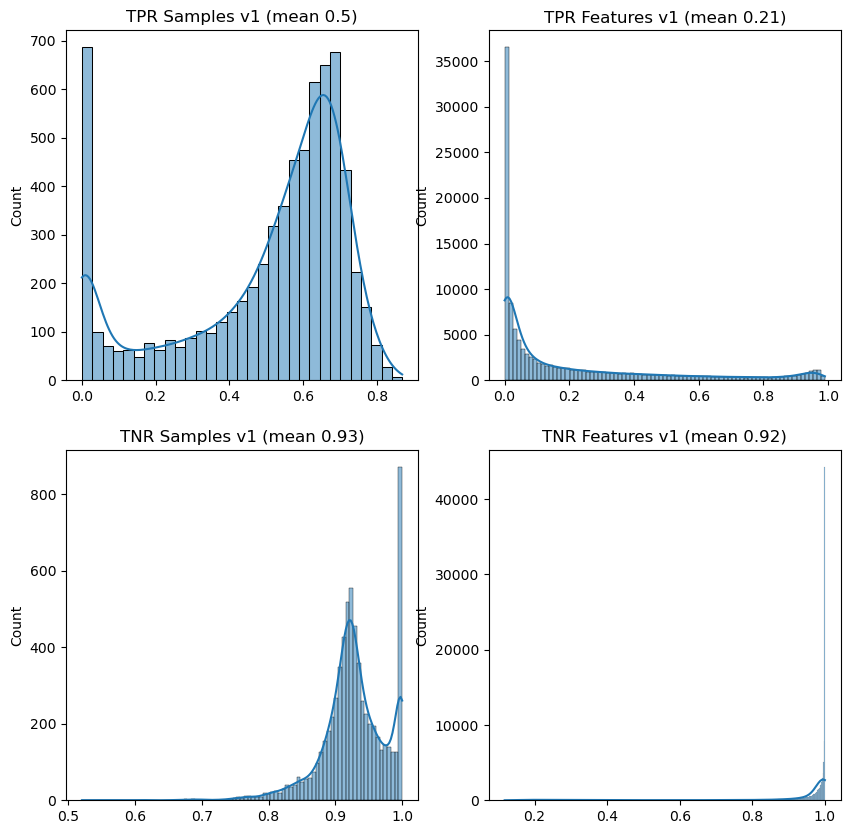

In [35]:
# plot tpr and tnr histograms
# columns presents sample-wise and feature-wise
# rows present tpr and tnr (v1 and 2)
print("version 1: mean before")
print("version 2: mean after")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(tpr_samples, kde=True, ax=ax[0,0])
ax[0,0].set_title("TPR Samples v1 (mean "+f"{round(tpr_samples.mean().item(),2)})")
sns.histplot(tpr_feature, kde=True, ax=ax[0,1])
ax[0,1].set_title("TPR Features v1 (mean "+f"{round(tpr_feature.mean().item(),2)})")
sns.histplot(tnr_samples, kde=True, ax=ax[1,0])
ax[1,0].set_title("TNR Samples v1 (mean "+f"{round(tnr_samples.mean().item(),2)})")
sns.histplot(tnr_feature, kde=True, ax=ax[1,1])
ax[1,1].set_title("TNR Features v1 (mean "+f"{round(tnr_feature.mean().item(),2)})")

plt.show()

In [36]:
ba_samples = (tpr_samples + tnr_samples) / 2
ba_feature = (tpr_feature + tnr_feature) / 2

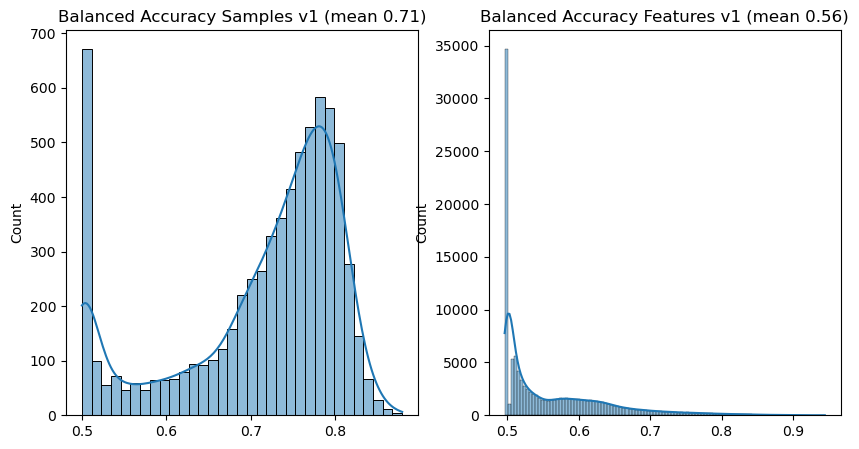

In [37]:
# plot histograms of the balanced accuracy

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba_samples, kde=True, ax=ax[0])
ax[0].set_title("Balanced Accuracy Samples v1 (mean "+f"{round(ba_samples.mean().item(),2)})")
sns.histplot(ba_feature, kde=True, ax=ax[1])
ax[1].set_title("Balanced Accuracy Features v1 (mean "+f"{round(ba_feature.mean().item(),2)})")

plt.show()

### spearman correlation